In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import gc

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

In [ ]:
# 特徴量エンジニアリング 
# 1.Ageのnan(177)　-> 各Pclass(1, 2, 3)のAgeの平均を求める。Ageが欠損しているデータのPclassを確認して、classの年齢平均値を代入する。
# 2.Cabinのnan(687) -> 
# 3.Cabin

In [2]:
df = pd.read_csv('train.csv')
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
type(df['Fare'])

pandas.core.series.Series

## ベースライン作成

### データセットの作成

In [3]:
x_train, y_train, id_train = df[['Pclass', 'Fare']], df[['Survived']], df[['PassengerId']]

In [4]:
print(x_train.shape)
print(y_train.shape)

(891, 2)
(891, 1)


### ベースライン検証用データの作成 

In [5]:
# ベースライン検証用データ(x_va, y_va)の作成
x_tr, x_va, y_tr, y_va = train_test_split(x_train, y_train,
                                          test_size=0.2,
                                          shuffle=True,
                                          stratify=y_train,
                                          random_state=123)

In [191]:
print(x_tr.shape, y_tr.shape)
print(x_va.shape, y_va.shape) # ベースライン検証データ

(712, 2) (712, 1)
(179, 2) (179, 1)


### ホールドアウト検証

In [6]:
# 学習データ(x_tr1,y_tr1)と検証データ(x_va1,y_va1)の分割
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr, y_tr,
                                              test_size=0.2,
                                              shuffle=True,
                                              stratify=y_tr,
                                              random_state=789)

In [176]:
print(x_tr1.shape, y_tr1.shape) # 学習データ
print(x_va1.shape, y_va1.shape) # 検証データ

(712,) (569, 1)
(143, 2) (143, 1)


### モデル学習

In [9]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain'
}

model = lgb.LGBMClassifier(**params)
model.fit(x_tr1, y_tr1,
          eval_set=[(x_tr1, y_tr1), (x_va1, y_va1)],
          callbacks=[lgb.early_stopping(stopping_rounds=100,
                                        verbose=10)])

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	training's auc: 0.76929	valid_1's auc: 0.719731
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.770505	valid_1's auc: 0.719008
[3]	training's auc: 0.782483	valid_1's auc: 0.726653
[4]	training's auc: 0.785181	valid_1's auc: 0.727273
[5]	training's auc: 0.784534	valid_1's auc: 0.727789
[6]	training's auc: 0.786508	valid_1's auc: 0.727066
[7]	training's auc: 0.787396	valid_1's auc: 0.729545
[8]	training's auc: 0.787449	valid_1's auc: 0.727273
[9]	training's auc: 0.789004	valid_1's auc: 0.729545
[10]	training's auc: 0.792153	valid_1's auc: 0.72562
[11]	training's auc: 0.794937	valid_1's auc: 0.725207
[12]	training's auc: 0.798609	valid_1's auc: 0.717459
[13]	training's auc: 0.804673	valid_1's auc: 0.718285
[14]	training's auc: 0.805667	valid_1's auc: 0.717252
[15]	training's auc: 0.807287	valid_1's auc: 0.715289
[16]	training's auc: 0.809287	valid_1's auc: 0.709091
[17]	training's auc: 0.809764	valid_1's auc: 0.710227
[18]	training's auc: 0.809659	v

LGBMClassifier(importance_type='gain', metric='auc', n_estimators=100000,
               num_leaves=16, objective='binary', random_state=123)

### 精度の評価

In [16]:
# 予測値算出
y_va1_pred = model.predict(x_va1) # 検証データ
y_va_pred = model.predict(x_va) # ベースライン検証用データ

# 精度評価
metric_va1 = accuracy_score(y_va1, y_va1_pred) # 検証データ
metric_va = accuracy_score(y_va, y_va_pred) # ベースライン検証用データ
print(f'[検証用データ]acc：{metric_va1:.4f}')
print(f'[ベースライン検証用データ]acc：{metric_va:.4f}')

[検証用データ]acc：0.7133
[ベースライン検証用データ]acc：0.7095


In [13]:
# 説明変数の重要度の算出
imp = pd.DataFrame({
    'col': x_train.columns,
    'imp': model.feature_importances_,
})
imp.sort_values('imp', ascending=False, ignore_index=True)

,col,imp
0,Fare,417.358917
1,Pclass,133.153509


In [17]:
# 誤差分布の比較
print('検証用データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))
print('-'*40)
print('ベースライン検証用データ')
print(confusion_matrix(y_va, y_va_pred))
print(confusion_matrix(y_va, y_va_pred, normalize='all'))

検証用データ
[[76 12]
 [29 26]]
[[0.53146853 0.08391608]
 [0.2027972  0.18181818]]
----------------------------------------
ベースライン検証用データ
[[92 18]
 [34 35]]
[[0.51396648 0.10055866]
 [0.18994413 0.19553073]]


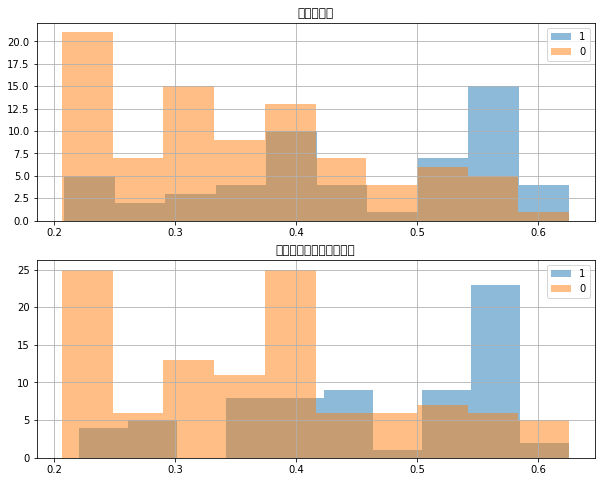

In [25]:
# 予測値の分布比較

# 予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1] # 検証用
y_va_pred_prob = model.predict_proba(x_va)[:,1] # ベースライン検証用

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))

# 検証データ
fig.add_subplot(2, 1, 1)
plt.title('検証データ')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

# ベースライン検証データ
fig.add_subplot(2, 1, 2)
plt.title('ベースライン検証データ')
plt.hist(y_va_pred_prob[np.array(y_va).reshape(-1)==1], bins=10, alpha=0.5, label='1')
plt.hist(y_va_pred_prob[np.array(y_va).reshape(-1)==0], bins=10, alpha=0.5, label='0')
plt.grid()
plt.legend()

## モデル推論

In [30]:
df_test = pd.read_csv('test.csv')
x_test = df_test[['Pclass', 'Fare']]
id_test = df_test[['PassengerId']]

In [32]:
# 学習モデルによる推論
y_test_pred = model.predict(x_test)

In [34]:
# 提出ファイルの作成
df_submit = pd.DataFrame({
    'PassengerId': id_test['PassengerId'],
    'Survived': y_test_pred,
})
display(df_submit.head(5))
df_submit.to_csv('titanic_submission_baseline.csv', index=None)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
